In [1]:
import warnings
from rdkit import RDLogger

# 屏蔽 RDKit 警告
RDLogger.DisableLog('rdApp.*')

# 或屏蔽所有 Python 警告
warnings.filterwarnings("ignore")
# 屏蔽 LightGBM 警告
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import optuna
from rdkit.Chem import Descriptors, AllChem
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import optuna
from rdkit.Chem import Descriptors, AllChem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# 数据预处理
df = pd.read_csv('../Dataset/imputed_selected_features_Reactivity.csv')
labels = df['Reactivity'].values
smiles_list = df['SMILES'].tolist()


# 函数：将SMILES转换为分子描述符和指纹
def smiles_to_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # 提取描述符
    descriptors = [
        Descriptors.MolWt(mol),  # 分子量
        Descriptors.MolLogP(mol),  # LogP
        Descriptors.NumHDonors(mol),  # 氢键供体数量
        Descriptors.NumHAcceptors(mol)  # 氢键受体数量
    ]
    # 生成Morgan指纹
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fingerprint_array = np.zeros((2048,))
    Chem.DataStructs.ConvertToNumpyArray(fingerprint, fingerprint_array)
    # 合并描述符和指纹
    features = np.concatenate([descriptors, fingerprint_array])
    return features

# 将SMILES转换为特征
features = []
for smiles in smiles_list:
    feature = smiles_to_features(smiles)
    if feature is not None:
        features.append(feature)

# 转换为numpy数组
features = np.array(features)

# 获取原始数据集中的其他特征（从第二列到倒数第二列）
additional_features = df.iloc[:, 1:-2].values

# 合并所有特征
all_features = np.hstack((features, additional_features))

# 标准化特征
scaler = StandardScaler()
all_features = scaler.fit_transform(all_features)







y = labels
X = np.array(all_features)
# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size=0.2, random_state=42)



# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_auc_score

# # 定义函数进行单次模型训练和评估
# def train_evaluate_xgboost(X_train, y_train, X_test, y_test):
#     model = XGBClassifier(
#         n_estimators=79, max_depth=17, learning_rate=0.12481772381820642, random_state=42, eval_metric='logloss'
#     )
#     model.fit(X_train, y_train)
#     y_prob = model.predict_proba(X_test)[:, 1]
#     auc_score = roc_auc_score(y_test, y_prob)
#     return auc_score

# # 原始标签的模型性能
# original_auc = train_evaluate_xgboost(X_train, y_train, X_test, y_test)
# print(f"Original AUC: {original_auc:.4f}")

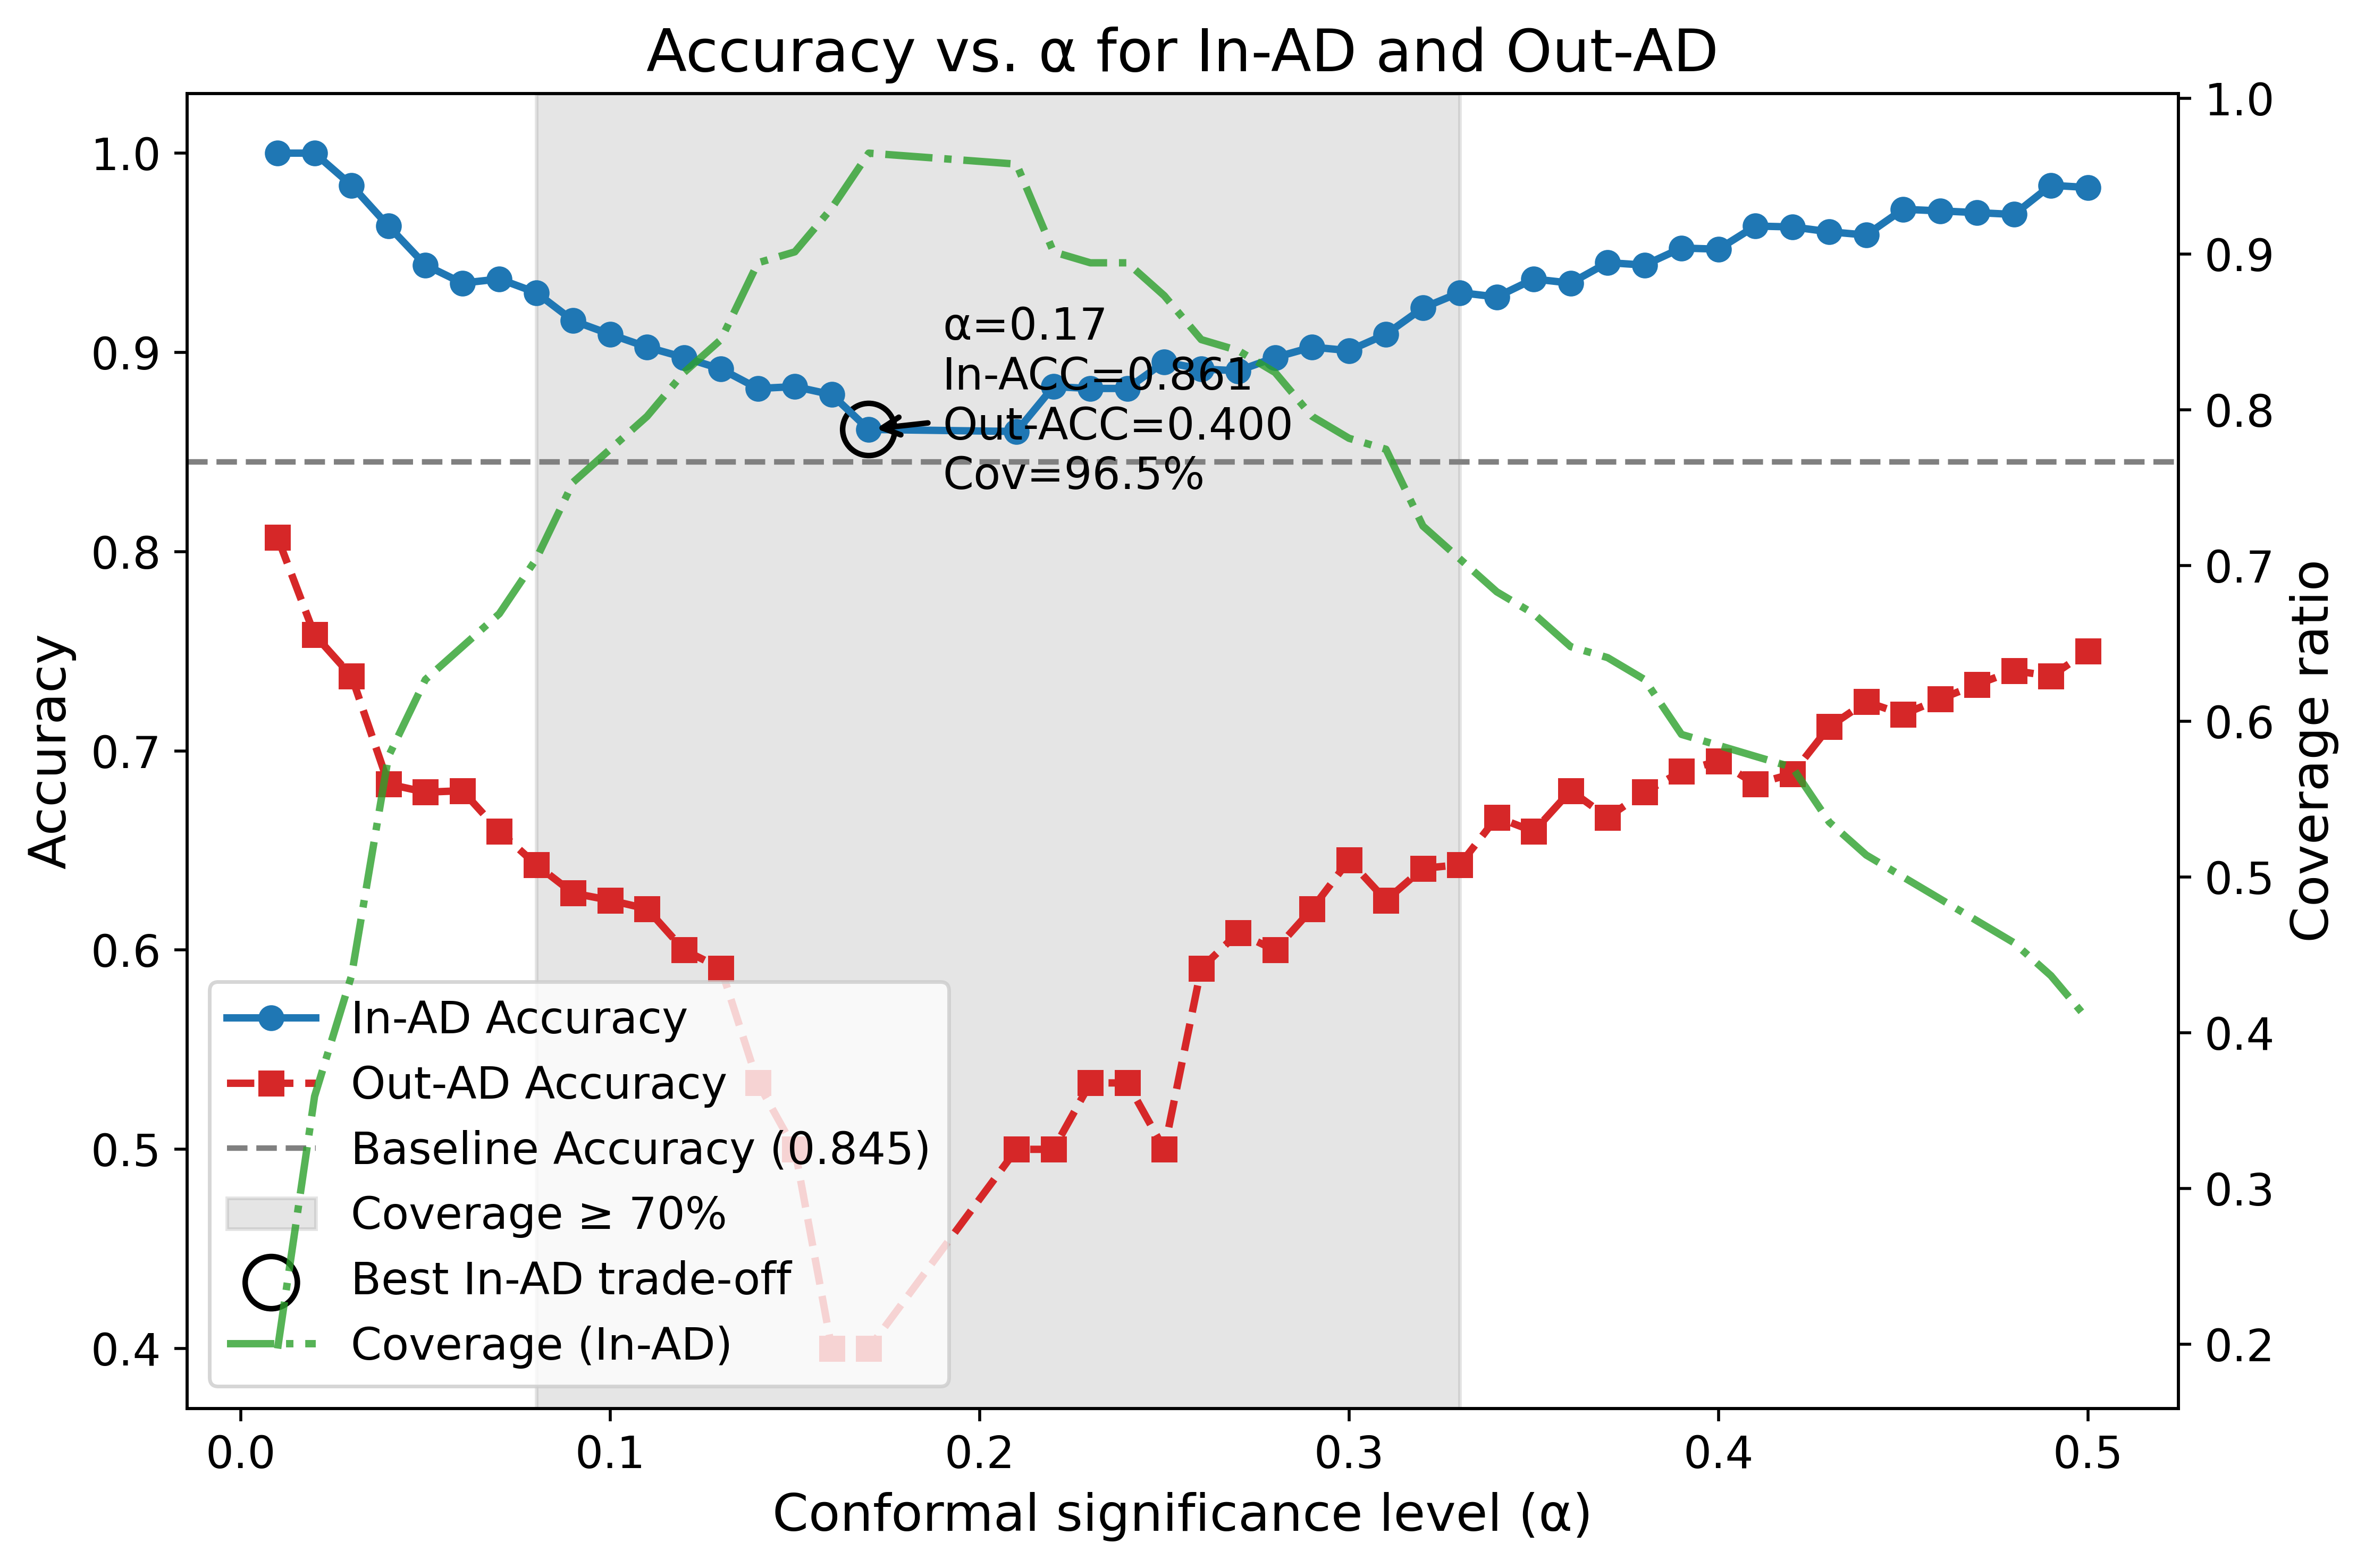

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from mapie.classification import MapieClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# 1. 拟合基模型并获取预测结果与 baseline Accuracy
base = XGBClassifier(
    n_estimators=79, max_depth=17,
    learning_rate=0.12481772381820642,
    random_state=42, eval_metric='logloss',
    use_label_encoder=False
)
base.fit(X_train, y_train)
y_pred = base.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)

# 2. MAPIE 校准器
mapie = MapieClassifier(
    estimator=base, 
    method="score",
    cv=StratifiedKFold(5, shuffle=True, random_state=42)
)
mapie.fit(X_train, y_train)

# 3. 扫描 α，计算 In-AD/Out-AD 的 Accuracy 和覆盖率
alphas = np.linspace(0.01, 0.5, 50)
records = []
for α in alphas:
    preds, ps = mapie.predict(X_test, alpha=α)
    mask_in  = ((ps > α).sum(1) == 1).ravel()
    mask_out = ~mask_in
    n_in  = mask_in.sum()
    n_out = mask_out.sum()
    cov = n_in / len(y_test)
    if n_in < 5 or n_out < 5:
        continue
    acc_in  = accuracy_score(y_test[mask_in], preds[mask_in])
    acc_out = accuracy_score(y_test[mask_out], preds[mask_out])
    records.append((α, cov, acc_in, acc_out))

αs, covs, acc_ins, acc_outs = map(np.array, zip(*records))

# 4. 找到“最佳 trade-off”点（acc_in * coverage 最大）
scores = acc_ins * covs
best = np.argmax(scores)
α_best, cov_best, acc_in_best, acc_out_best = αs[best], covs[best], acc_ins[best], acc_outs[best]

# 5. 覆盖率 ≥ 70% 的 α 范围
min_cov = 0.70
mask_cov70 = covs >= min_cov
α_min70, α_max70 = αs[mask_cov70].min(), αs[mask_cov70].max()

# 6. 绘图（Accuracy 版）
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=500)  # 提高 DPI

# In-AD 和 Out-AD Accuracy 曲线
ax1.plot(αs, acc_ins,  '-o', label='In-AD Accuracy',  color='tab:blue', markersize=6, linewidth=2)
ax1.plot(αs, acc_outs,'--s', label='Out-AD Accuracy', color='tab:red',  markersize=6, linewidth=2)

# baseline accuracy
ax1.axhline(baseline_acc, color='gray', linestyle='--', linewidth=1.5,
            label=f'Baseline Accuracy ({baseline_acc:.3f})')

# 坐标轴标签
ax1.set_xlabel("Conformal significance level (α)", fontsize=14)
ax1.set_ylabel("Accuracy", fontsize=14)
ax1.set_title("Accuracy vs. α for In-AD and Out-AD", fontsize=16)

# 增大刻度字体
ax1.tick_params(axis='both', which='major', labelsize=12)

# 高亮覆盖率 ≥ min_cov 的 α 区间
ax1.axvspan(α_min70, α_max70, color='gray', alpha=0.2,
            label=f"Coverage ≥ {int(min_cov*100)}%")

# 标注最佳 trade-off 点
ax1.scatter(α_best, acc_ins[best], s=200, facecolors='none',
            edgecolors='black', linewidths=1.5, label='Best In-AD trade-off')
ax1.annotate(
    f"α={α_best:.2f}\nIn-ACC={acc_in_best:.3f}\nOut-ACC={acc_out_best:.3f}\nCov={cov_best:.1%}",
    xy=(α_best, acc_ins[best]),
    xytext=(α_best+0.02, acc_ins[best]-0.03),
    fontsize=12,
    arrowprops=dict(arrowstyle="->", lw=1.5)
)

# 次坐标轴：Coverage
ax2 = ax1.twinx()
ax2.plot(αs, covs, '-.', color='tab:green', alpha=0.8, label='Coverage (In-AD)', linewidth=2)
ax2.set_ylabel("Coverage ratio", fontsize=14)
ax2.tick_params(axis='y', labelsize=12)

# 合并图例并增大字体
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower left', fontsize=12, frameon=True)

plt.tight_layout()
plt.show()



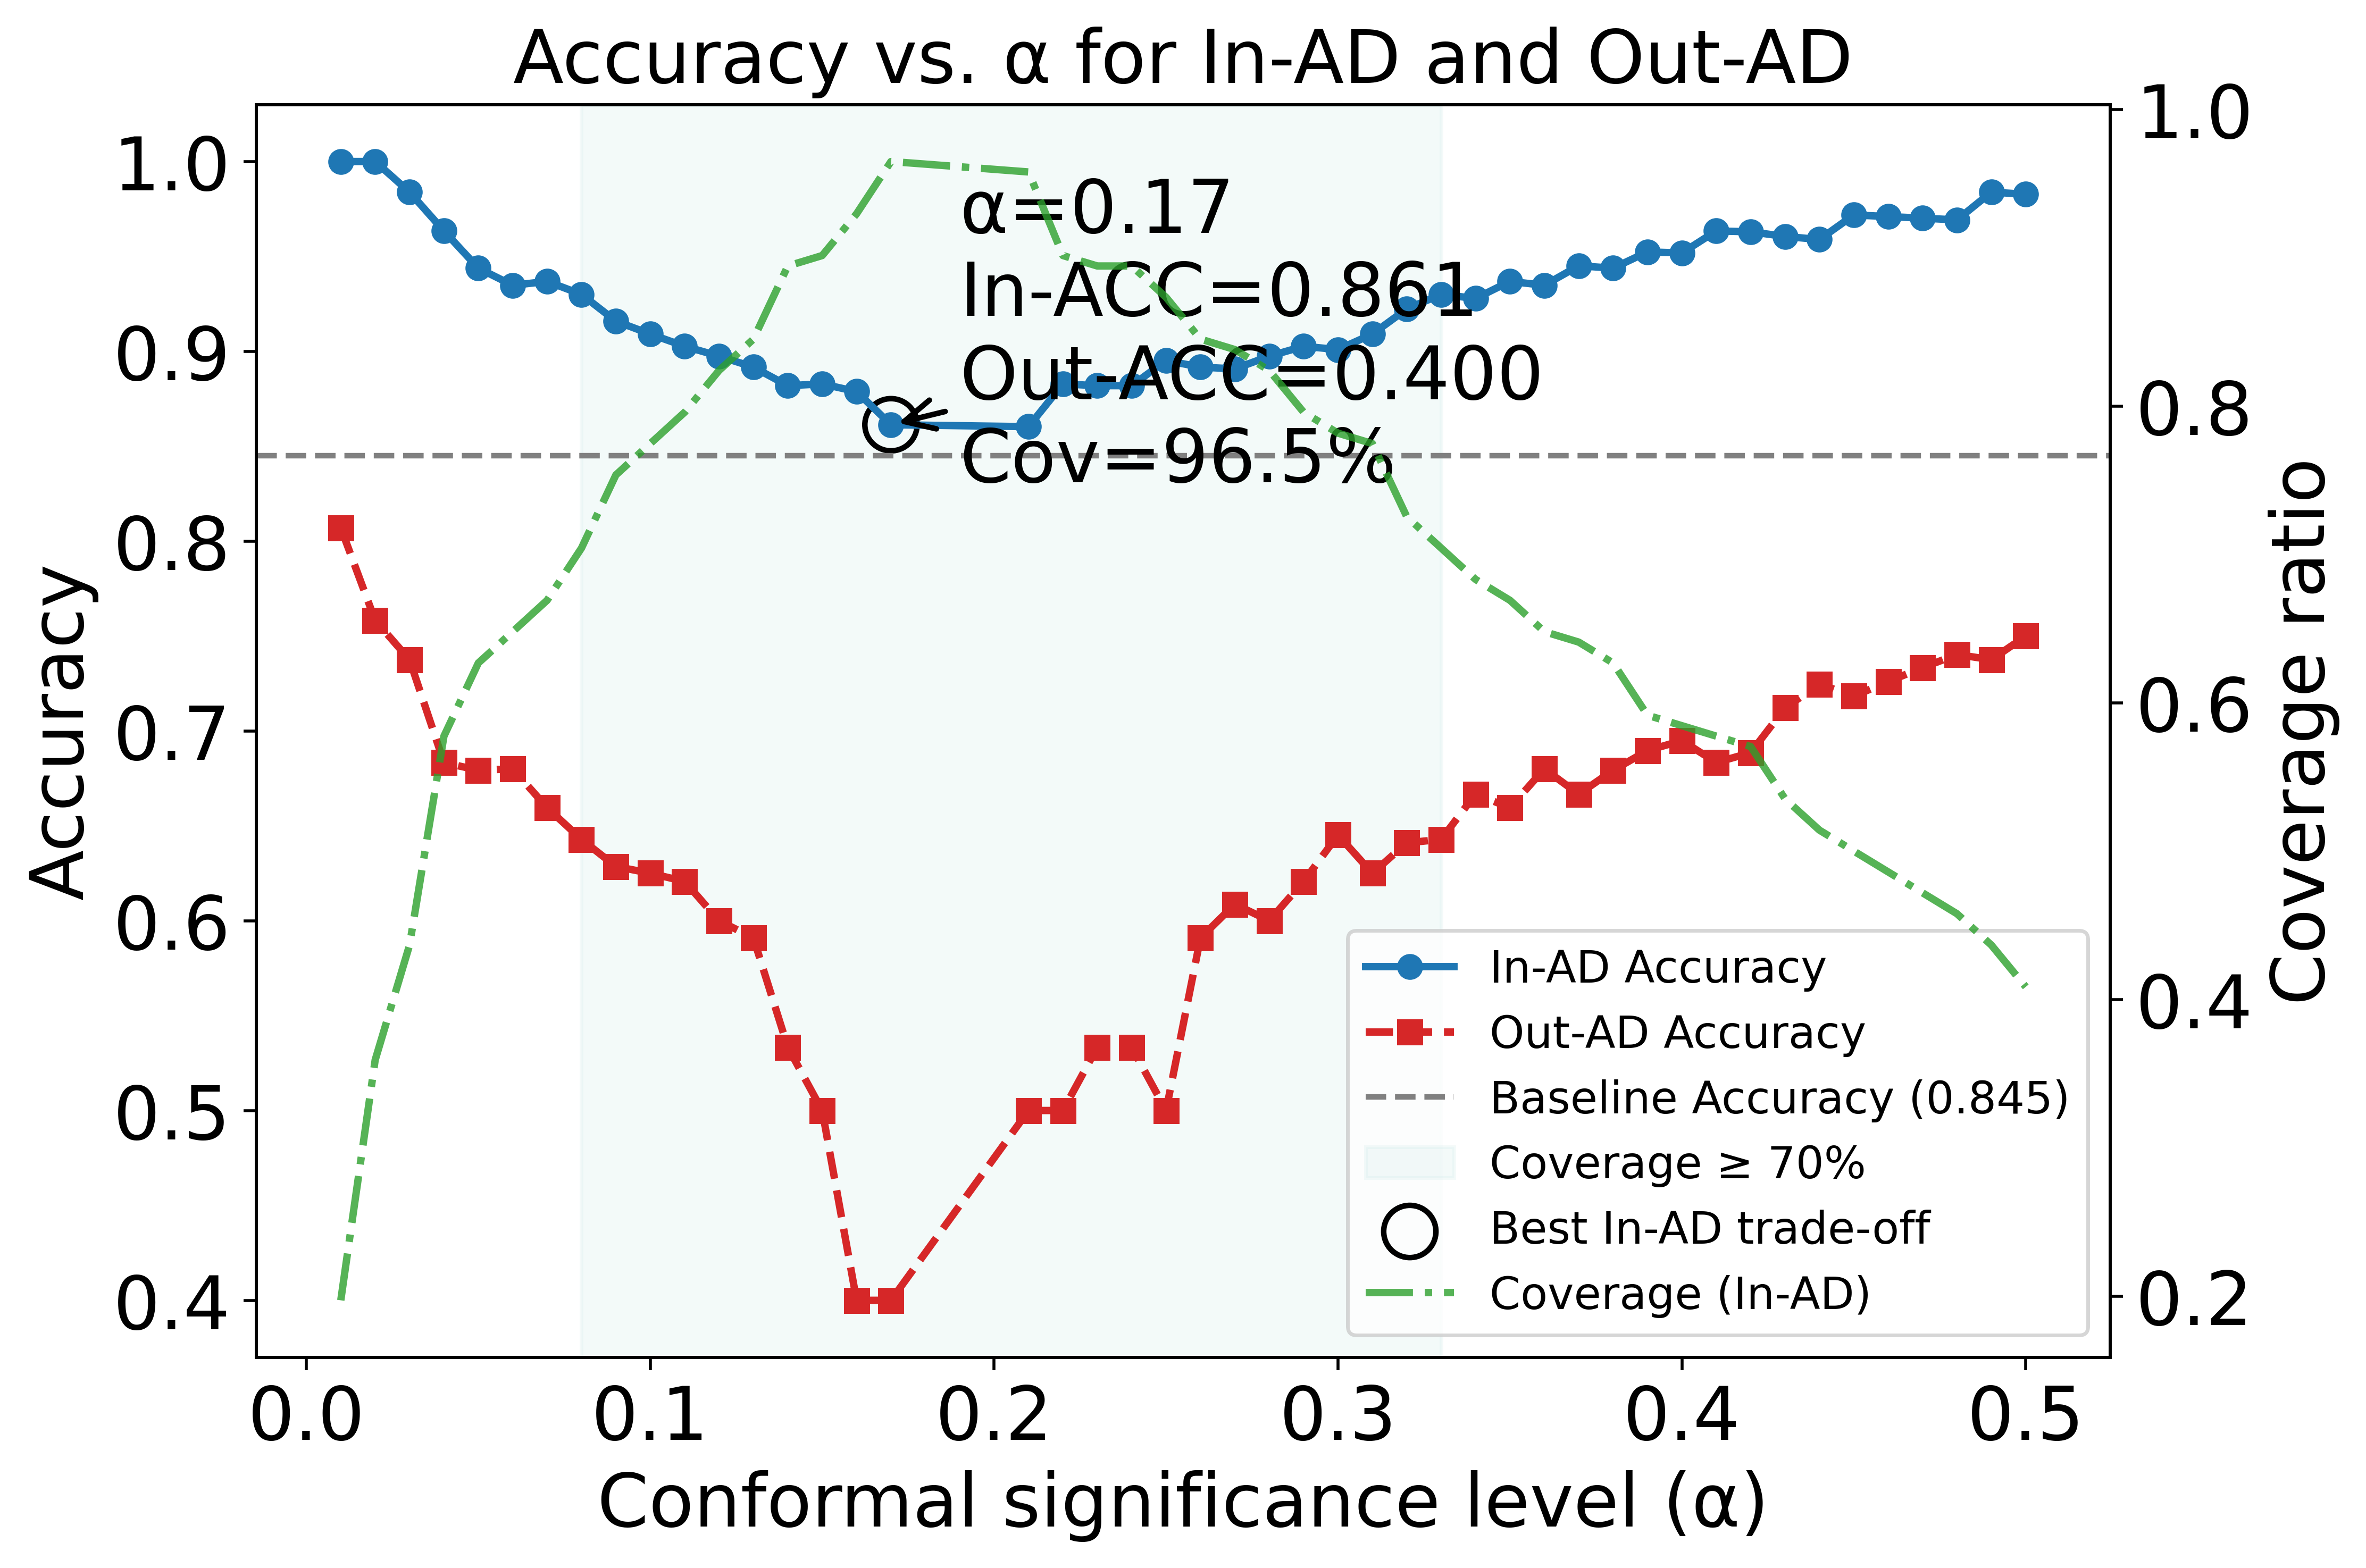

In [13]:
# 6. 绘图（优化版：Accuracy）
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=500)  # 提高 DPI

# In-AD 和 Out-AD Accuracy 曲线
ax1.plot(αs, acc_ins,  '-o', label='In-AD Accuracy',  color='tab:blue', markersize=6, linewidth=2)
ax1.plot(αs, acc_outs,'--s', label='Out-AD Accuracy', color='tab:red',  markersize=6, linewidth=2)

# baseline Accuracy
ax1.axhline(baseline_acc, color='gray', linestyle='--', linewidth=1.5,
            label=f'Baseline Accuracy ({baseline_acc:.3f})')

# 坐标轴标签与标题
ax1.set_xlabel("Conformal significance level (α)", fontsize=20)
ax1.set_ylabel("Accuracy", fontsize=20)
ax1.set_title("Accuracy vs. α for In-AD and Out-AD", fontsize=20)

# 增大刻度字体
ax1.tick_params(axis='both', which='major', labelsize=20)

# 高亮覆盖率 ≥ min_cov 时的 α 区间
ax1.axvspan(α_min70, α_max70, color='#C7E6E5', alpha=0.2,
            label=f"Coverage ≥ {int(min_cov*100)}%")

# 标注最佳 trade-off 点
ax1.scatter(α_best, acc_ins[best], s=200, facecolors='none',
            edgecolors='black', linewidths=1.5, label='Best In-AD trade-off')
ax1.annotate(
    f"α={α_best:.2f}\nIn-ACC={acc_in_best:.3f}\nOut-ACC={acc_out_best:.3f}\nCov={cov_best:.1%}",
    xy=(α_best, acc_ins[best]),
    xytext=(α_best+0.02, acc_ins[best]-0.03),
    fontsize=20,
    arrowprops=dict(arrowstyle="->", lw=1.5)
)

# 次坐标轴：Coverage
ax2 = ax1.twinx()
ax2.plot(αs, covs, '-.', color='tab:green', alpha=0.8, label='Coverage (In-AD)', linewidth=2)
ax2.set_ylabel("Coverage ratio", fontsize=20)
ax2.tick_params(axis='y', labelsize=20)

# 合并图例
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='lower right', fontsize=12, frameon=True)

plt.tight_layout()
plt.show()


In [14]:
import matplotlib.pyplot as plt
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
# plt.rcParams['xtick.labelsize'] = 20
# plt.rcParams['ytick.labelsize'] = 20

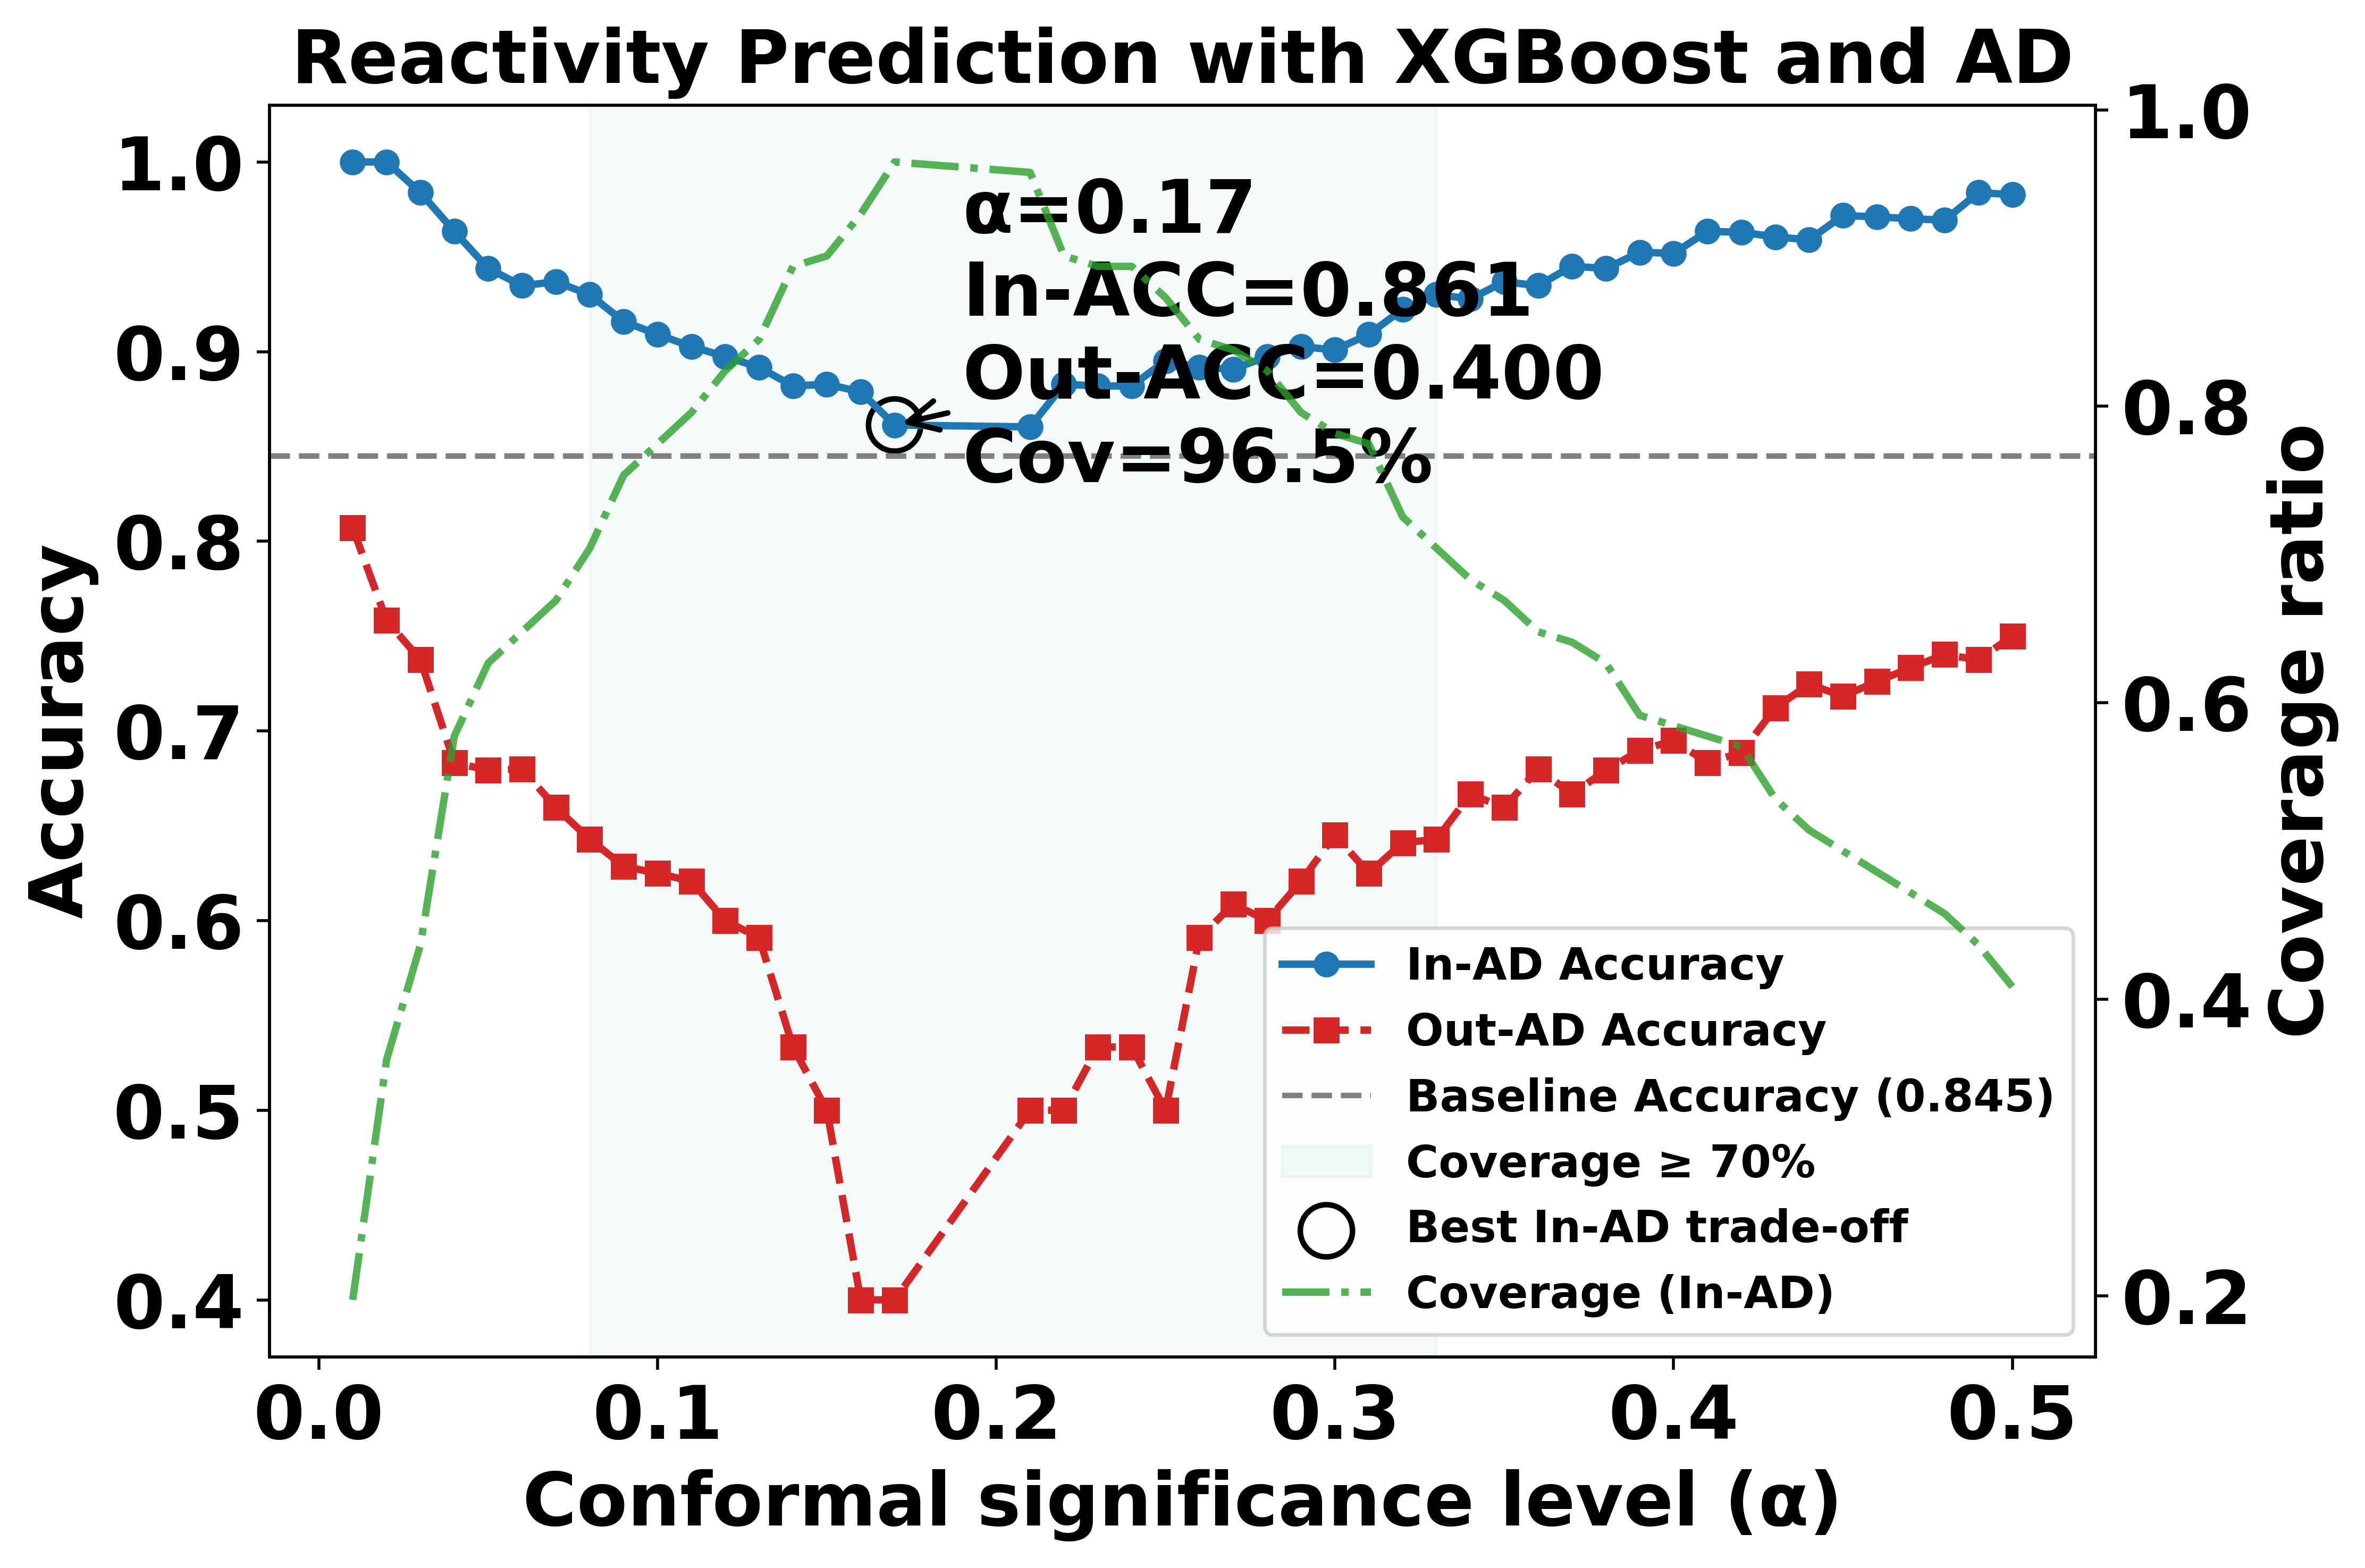

In [16]:
# 6. 绘图（优化版：Accuracy）
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=500)  # 提高 DPI

# In-AD 和 Out-AD Accuracy 曲线
ax1.plot(αs, acc_ins,  '-o', label='In-AD Accuracy',  color='tab:blue', markersize=6, linewidth=2)
ax1.plot(αs, acc_outs,'--s', label='Out-AD Accuracy', color='tab:red',  markersize=6, linewidth=2)

# baseline Accuracy
ax1.axhline(baseline_acc, color='gray', linestyle='--', linewidth=1.5,
            label=f'Baseline Accuracy ({baseline_acc:.3f})')

# 坐标轴标签与标题
ax1.set_xlabel("Conformal significance level (α)", fontsize=20)
ax1.set_ylabel("Accuracy", fontsize=20)
ax1.set_title("Reactivity Prediction with XGBoost and AD", fontsize=20)

# 增大刻度字体
ax1.tick_params(axis='both', which='major', labelsize=20)

# 高亮覆盖率 ≥ min_cov 时的 α 区间
ax1.axvspan(α_min70, α_max70, color='#C7E6E5', alpha=0.2,
            label=f"Coverage ≥ {int(min_cov*100)}%")

# 标注最佳 trade-off 点
ax1.scatter(α_best, acc_ins[best], s=200, facecolors='none',
            edgecolors='black', linewidths=1.5, label='Best In-AD trade-off')
ax1.annotate(
    f"α={α_best:.2f}\nIn-ACC={acc_in_best:.3f}\nOut-ACC={acc_out_best:.3f}\nCov={cov_best:.1%}",
    xy=(α_best, acc_ins[best]),
    xytext=(α_best+0.02, acc_ins[best]-0.03),
    fontsize=20,
    arrowprops=dict(arrowstyle="->", lw=1.5)
)

# 次坐标轴：Coverage
ax2 = ax1.twinx()
ax2.plot(αs, covs, '-.', color='tab:green', alpha=0.8, label='Coverage (In-AD)', linewidth=2)
ax2.set_ylabel("Coverage ratio", fontsize=20)
ax2.tick_params(axis='y', labelsize=20)

# 合并图例
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='lower right', fontsize=12, frameon=True)

plt.tight_layout()
plt.show()